In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

In [63]:
from PIL import Image

def read_calibration_data(filepath):
    calibration_data = {}
    with open(filepath, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                try:
                    # Convert numerical values to floats
                    calibration_data[key] = float(value)
                except ValueError:
                    # Keep string values as-is
                    calibration_data[key] = value
    return calibration_data

def calculate_offsets(calibration_data):
    # Calculate pixels per meter
    ppm_x = calibration_data["optical-calibration.image-width"] / calibration_data["optical-calibration.region.width"]
    ppm_y = calibration_data["optical-calibration.image-height"] / calibration_data["optical-calibration.region.height"]
    
    # Calculate the global position in pixels
    global_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]*ppm_y #calibration_data["optical-calibration.region.x"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    global_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]*ppm_x #calibration_data["optical-calibration.region.y"] - calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.y"]
    
    # Calculate the offsets
    offset_x = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    offset_y = calibration_data["optical-calibration.scanner-environment.xy-scanner.motorstage.position.x"]
    
    return ppm_x, ppm_y, global_x, global_y, offset_x, offset_y

def create_composite_image(image_paths, calibration_files, output_path):
    # Read calibration data from files
    calibration_datas = [read_calibration_data(file) for file in calibration_files]
    
    # Load images and rotate them by -90 degrees to align with the global coordinate system
    images = [Image.open(path).rotate(90, expand=True) for path in image_paths]
    
    # Calculate offsets and pixels per meter for each image
    calculations = [calculate_offsets(data) for data in calibration_datas]
    
    # Determine the canvas size
    canvas_width_meters = max([abs(c[2]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[2] is global_x
    canvas_height_meters = max([abs(c[3]) + data["optical-calibration.image-width"] for c, data in zip(calculations, calibration_datas)]) #c[3] is global_y
    
    # Assume the pixels per meter is the same for both images, as indicated by calibration data
    ppm_x, ppm_y = calculations[0][:2] 
    
    # Create the canvas
    canvas_width_pixels = int(round(canvas_width_meters))
    canvas_height_pixels = int(round(canvas_height_meters))
    canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))
    
    # Paste images onto the canvas
    for (ppm_x, ppm_y, global_x, global_y, offset_x, offset_y), image in zip(calculations, images):
        position_x = int(round((offset_x)))
        position_y = int(round((offset_y)))
        canvas.paste(image, (position_x, position_y))
    
    # Save the composite image
    canvas.save(output_path)
    print(f"Composite image saved to {output_path}")


In [64]:
import os
import glob

# Directory containing the 'tiling_x' folders
parent_directory = './tiling/'

# Glob pattern to match folders
folder_pattern = os.path.join(parent_directory, 'tiling-*')
folders = sorted(glob.glob(folder_pattern), key=lambda x: os.path.basename(x).split('-')[1:])

# Lists to hold the paths
image_paths = []
calibration_files = []
tiling_vars = {}

# Iterate through each folder
for folder in folders:
    # Extract folder name to dynamically create variable-like dictionary keys
    folder_name = os.path.basename(folder)
    tiling_vars[folder_name] = folder

    # Find all jpg images in the folder
    jpg_files = glob.glob(os.path.join(folder, 'snapshot-*.jpg'))
    image_paths.extend(jpg_files)

    # Find all calibration files in the folder
    cal_files = glob.glob(os.path.join(folder, 'optical-calibration-*.txt'))
    calibration_files.extend(cal_files)

    # Optionally open the first calibration file found in each folder
    if cal_files:
        first_cal_file = cal_files[0]
        print(f"Opening file: {first_cal_file}")
        # Here you can add your logic to open and process the file

# Output paths for demonstration purposes
output_path = './result.jpg'

# Print variables and paths for verification
print(f"Tiling folder variables: {tiling_vars}")
print(f"Image paths: {image_paths}")
print(f"Calibration files: {calibration_files}")
print(f"Output path: {output_path}")





Opening file: ./tiling/tiling-10.10.12.421/optical-calibration-2024.02.15-10.10.18-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.10.35.701/optical-calibration-2024.02.15-10.10.45-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.11.18.511/optical-calibration-2024.02.15-10.11.27-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.11.46.586/optical-calibration-2024.02.15-10.12.02-snapshot-000-transformed001.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.12.30.722/optical-calibration-2024.02.15-10.12.39-snapshot-000-transformed004.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.12.57.277/optical-calibration-2024.02.15-10.13.06-snapshot-000-transformed001.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.13.24.895/optical-calibration-2024.02.15-10.13.33-snapshot-000-transformed.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.13.48.615/optical-calibration-2024.02.15-10.14.06-snapshot-000.jpk-opt-cal.txt
Opening file: ./tiling/tiling-10.14.22.158/opti

In [65]:
calibrations = []
for file in calibration_files:
    calibration_data = read_calibration_data(file)
    calibrations.append(calibration_data)

calculations = []
for calibration in calibrations:
    calculation_data = calculate_offsets(calibration)
    calculations.append(calculation_data)

In [66]:
df = pd.DataFrame(calculations, columns = ['ppm_x', 'ppm_y', 'global_x', 'global_y', 'x in m', 'y in um'])

In [67]:
y_min = df.min()[3]
x_max = df.max()[2]
df['y_offset'] = -df['global_y']
df['x_offset'] = abs((df['global_x']-x_max))

/tmp/ipykernel_8501/1128668261.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_min = df.min()[3]
/tmp/ipykernel_8501/1128668261.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_max = df.max()[2]


In [68]:
df

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset
0,406636.945773,406617.224713,971.980615,-1523.194516,0.002390,0.002390,1523.194516,0.000000
1,406636.945773,406617.224713,966.154591,-1034.653671,0.002376,0.002376,1034.653671,5.826024
2,406636.945773,406617.224713,966.696547,-601.771950,0.002377,0.002377,601.771950,5.284068
3,406636.945773,406617.224713,312.826993,-1609.323962,0.000769,0.000769,1609.323962,659.153622
4,406636.945773,406617.224713,302.258857,-1217.746456,0.000743,0.000743,1217.746456,669.721758
5,406636.945773,406617.224713,299.549078,-808.089892,0.000737,0.000737,808.089892,672.431537
6,406636.945773,406617.224713,301.513667,-435.945681,0.000742,0.000742,435.945681,670.466948
7,406636.945773,406617.224713,-524.426822,-1596.797274,-0.001290,-0.001290,1596.797274,1496.407437
8,406636.945773,406617.224713,-504.713183,-1244.221781,-0.001241,-0.001241,1244.221781,1476.693798
9,406636.945773,406617.224713,-515.213575,-832.601574,-0.001267,-0.001267,832.601574,1487.194190


In [69]:
canvas_width_pixels = df['y_offset'].max()+1024 #c[2] is global_x
canvas_height_pixels = df['x_offset'].max()+924 #c[3] is global_y

# Create the canvas
canvas_width_pixels = int(canvas_width_pixels)
canvas_height_pixels = int(canvas_height_pixels)
canvas = Image.new('RGB', (canvas_width_pixels, canvas_height_pixels), (0, 0, 0))


# List to hold the cropped images
cropped_images = []

# Loop through each image path
for path in image_paths:
    # Open and rotate the image (though here rotation is set to 0, so it's not actually changing the image)
    image = Image.open(path).rotate(0, expand=True)
    
    # Get the size of the image
    width, height = image.size
    
    # Define the cropping box. Remove the right 200 pixels
    crop_box = (0, 0, width - 100, height)
    
    # Crop the image
    cropped_img = image.crop(crop_box)
    # Add the cropped image to the list
    cropped_images.append(cropped_img)

df['image_path'] = cropped_images


In [70]:
# Step 2: Sort the DataFrame by 'y_offset' in descending order
df_sorted = df.sort_values(by='y_offset', ascending=False)
df_sorted = df_sorted.sort_values(by='x_offset', ascending=True)
#df_sorted = df_sorted[df_sorted['y_offset'] <= 1000]
df_sorted.loc[df_sorted['y_offset'] > 800, 'x_offset'] += 20
df_sorted.loc[df_sorted['x_offset'] > 1000, 'x_offset'] -= 10
# df_sorted.loc[(df_sorted['x_offset'] > 100) & (df_sorted['y_offset'] > 800), 'x_offset'] -= 10
# df_sorted.loc[(df_sorted['x_offset'] > 1000) , 'x_offset'] -= 30
# df_sorted.iloc[4, df_sorted.columns.get_loc('x_offset')] -= 10

# df_sorted.loc[df_sorted['x_offset'] > 1000, 'y_offset'] += 10

In [71]:
df_sorted

,ppm_x,ppm_y,global_x,global_y,x in m,y in um,y_offset,x_offset,image_path
0,406636.945773,406617.224713,971.980615,-1523.194516,0.002390,0.002390,1523.194516,20.000000,<PIL.Image.Image image mode=L size=924x1024 at...
2,406636.945773,406617.224713,966.696547,-601.771950,0.002377,0.002377,601.771950,5.284068,<PIL.Image.Image image mode=L size=924x1024 at...
1,406636.945773,406617.224713,966.154591,-1034.653671,0.002376,0.002376,1034.653671,25.826024,<PIL.Image.Image image mode=L size=924x1024 at...
3,406636.945773,406617.224713,312.826993,-1609.323962,0.000769,0.000769,1609.323962,679.153622,<PIL.Image.Image image mode=L size=924x1024 at...
4,406636.945773,406617.224713,302.258857,-1217.746456,0.000743,0.000743,1217.746456,689.721758,<PIL.Image.Image image mode=L size=924x1024 at...
6,406636.945773,406617.224713,301.513667,-435.945681,0.000742,0.000742,435.945681,670.466948,<PIL.Image.Image image mode=L size=924x1024 at...
5,406636.945773,406617.224713,299.549078,-808.089892,0.000737,0.000737,808.089892,692.431537,<PIL.Image.Image image mode=L size=924x1024 at...
8,406636.945773,406617.224713,-504.713183,-1244.221781,-0.001241,-0.001241,1244.221781,1486.693798,<PIL.Image.Image image mode=L size=924x1024 at...
9,406636.945773,406617.224713,-515.213575,-832.601574,-0.001267,-0.001267,832.601574,1497.194190,<PIL.Image.Image image mode=L size=924x1024 at...
7,406636.945773,406617.224713,-524.426822,-1596.797274,-0.001290,-0.001290,1596.797274,1506.407437,<PIL.Image.Image image mode=L size=924x1024 at...


In [74]:
# Assuming `df` is your DataFrame and `cropped_images` is a list of image paths
# Step 1: Add the image paths to the DataFrame
df_sorted = df_sorted.sort_values(by='y_offset', ascending=False)

# Now you can loop through the sorted DataFrame
for i, row in df_sorted.iterrows():
    position_x = int(row['x_offset'])
    position_y = int(row['y_offset'])
    print(i)
    print(row)

    
    # Paste the image on the canvas at the specified position
    # Note: Adjust the order of position_x and position_y if necessary
    canvas.paste(row['image_path'], (position_y, position_x))

# Save the composite image
output_path = './compiled.tif'
canvas.save(output_path, format='TIFF')
print(f"Composite image saved to {output_path}")


3
ppm_x                                             406636.945773
ppm_y                                             406617.224713
global_x                                             312.826993
global_y                                           -1609.323962
x in m                                                 0.000769
y in um                                                0.000769
y_offset                                            1609.323962
x_offset                                             679.153622
image_path    <PIL.Image.Image image mode=L size=924x1024 at...
Name: 3, dtype: object
7
ppm_x                                             406636.945773
ppm_y                                             406617.224713
global_x                                            -524.426822
global_y                                           -1596.797274
x in m                                                 -0.00129
y in um                                                -0.00129
y_offset     

In [58]:
afm = pd.read_csv("./ZWV08_processed_forcecurves.tsv", sep = "\t")
afm['X Position'] = ((afm['X Position'])*df['ppm_x'][0]*(-1))+924+515
afm['Y Position'] = abs(((afm['Y Position'])*df['ppm_x'][1]*(-1)))+1024-575#-290


In [59]:
afm['Filename'] = afm['Filename'].str.split('-data', n=1, expand=True)[0]
tiling_1 = ['ZWV08_Location-1', 'ZWV08_Location-2', 'ZWV08_Location-3', 'ZWV08_Location-4', 'ZWV08_Location-5', 'ZWV08_Location-6']
afm_1 = afm[afm['Filename'].isin(tiling_1)]

afm_2 = afm[~afm['Filename'].isin(tiling_1)]

offset_x = min(afm_2['X Position'])-max(afm_1['X Position'])
Loc_6 = afm[afm['Filename'] == 'ZWV08_Location-6']
Loc_14 = afm_2[afm_2['Filename'] == 'ZWV08_Location-14']

# Find the maximum value in 'Y position' column of the filtered DataFrame
max_y_6 = Loc_6['Y Position'].max()
max_y_14 = Loc_14['Y Position'].max()

offset_y = max_y_14-max_y_6

afm_1['X Position'] += offset_x
afm_1['Y Position'] += offset_y
afm_1

/tmp/ipykernel_8501/3054250242.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afm_1['X Position'] += offset_x
/tmp/ipykernel_8501/3054250242.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afm_1['Y Position'] += offset_y


,Filename,Position Index,X Position,Y Position,Baseline Offset [N],Contact Point Offset [m],Young's Modulus [Pa],Contact Point [m],Baseline [N],ResidualRMS [N]
10597,ZWV08_Location-4,0,1027.971375,1864.434080,-1.320000e-10,0.000006,6591.750,-1.170000e-07,2.070000e-10,2.000000e-11
10598,ZWV08_Location-4,1,1027.975442,1868.244268,-2.430000e-10,0.000010,3648.900,-3.070000e-07,4.520000e-10,1.900000e-11
10599,ZWV08_Location-4,2,1027.979508,1872.058523,-6.120000e-11,0.000014,810.642,-1.110000e-06,4.590000e-10,2.090000e-11
10600,ZWV08_Location-4,3,1027.979508,1875.868711,-3.130000e-10,0.000014,530.804,4.590000e-06,-2.760000e-09,1.880000e-11
10601,ZWV08_Location-4,4,1027.983574,1879.682965,4.280000e-11,0.000014,511.714,4.160000e-06,-3.020000e-09,2.710000e-11
...,...,...,...,...,...,...,...,...,...,...
45637,ZWV08_Location-2,1019,909.867741,1723.481515,-9.940000e-10,0.000007,18506.900,-2.870000e-06,2.670000e-10,2.920000e-11
45638,ZWV08_Location-2,1020,909.871807,1727.295770,-4.560000e-10,0.000002,13781.600,1.080000e-08,-1.070000e-11,2.010000e-11
45639,ZWV08_Location-2,1021,909.875873,1731.105958,-5.190000e-10,0.000003,2273.110,-4.570000e-08,3.370000e-11,3.790000e-11
45640,ZWV08_Location-2,1022,909.875873,1734.920213,-5.210000e-10,NaN,113460.000,-1.280000e-06,-4.210000e-11,2.110000e-11


In [60]:
afm = pd.concat([afm_1, afm_2])
afm

,Filename,Position Index,X Position,Y Position,Baseline Offset [N],Contact Point Offset [m],Young's Modulus [Pa],Contact Point [m],Baseline [N],ResidualRMS [N]
10597,ZWV08_Location-4,0,1027.971375,1864.434080,-1.320000e-10,0.000006,6591.750,-1.170000e-07,2.070000e-10,2.000000e-11
10598,ZWV08_Location-4,1,1027.975442,1868.244268,-2.430000e-10,0.000010,3648.900,-3.070000e-07,4.520000e-10,1.900000e-11
10599,ZWV08_Location-4,2,1027.979508,1872.058523,-6.120000e-11,0.000014,810.642,-1.110000e-06,4.590000e-10,2.090000e-11
10600,ZWV08_Location-4,3,1027.979508,1875.868711,-3.130000e-10,0.000014,530.804,4.590000e-06,-2.760000e-09,1.880000e-11
10601,ZWV08_Location-4,4,1027.983574,1879.682965,4.280000e-11,0.000014,511.714,4.160000e-06,-3.020000e-09,2.710000e-11
...,...,...,...,...,...,...,...,...,...,...
45846,ZWV08_Location-43_2,204,1550.424216,1647.472938,NaN,NaN,NaN,NaN,NaN,NaN
45847,ZWV08_Location-43_2,205,1550.418117,1651.283126,NaN,NaN,NaN,NaN,NaN,NaN
45848,ZWV08_Location-43_2,206,1550.412017,1655.097380,5.060000e-09,0.000015,368.587,-2.580000e-07,1.830000e-10,3.640000e-11
45849,ZWV08_Location-43_2,207,1550.405917,1658.907568,4.840000e-09,0.000013,234.966,-2.790000e-06,3.960000e-10,1.910000e-11


In [61]:
afm.to_csv("./ZWV08_new/afm_new.csv", sep = ",")

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2540: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


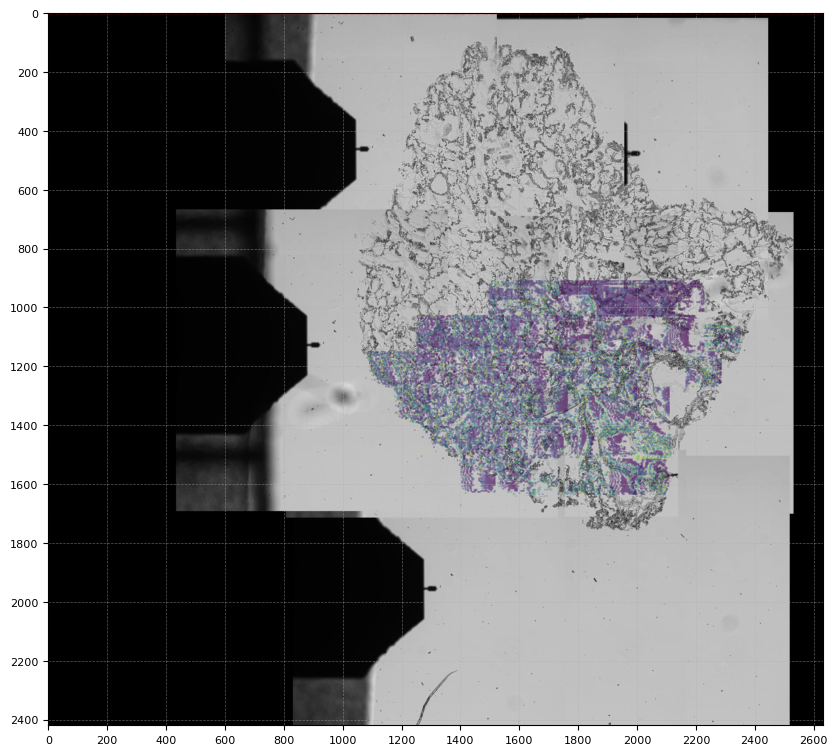

In [62]:
# Filter the data to exclude outliers
filtered_afm = afm[afm["Young's Modulus [Pa]"] < 10000]
filtered_afm = filtered_afm[filtered_afm["Young's Modulus [Pa]"] > 20]

afm_slide = cv2.imread('./result_new.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.1, alpha=0.5)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.savefig('Location_all.png', bbox_inches='tight')

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")

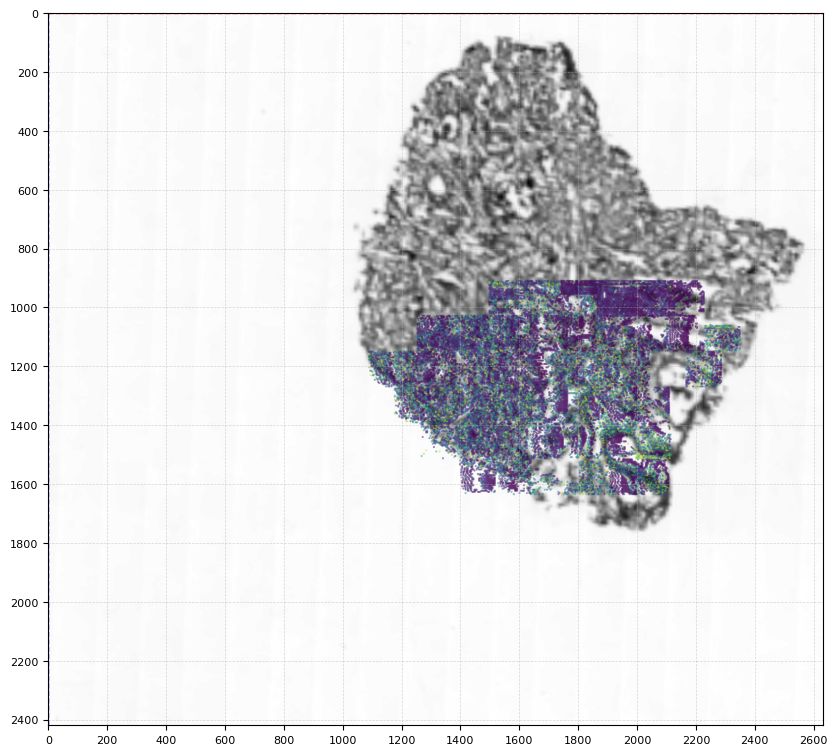

In [46]:
afm_slide = cv2.imread('./ZWV08_new/transformed_image-new3.tif', cv2.IMREAD_GRAYSCALE)

# Ensure that the dimensions of the canvas match the resized image
canvas_new = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas_new.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas_new = cv2.addWeighted(canvas_new, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas_new, cmap='gray')  # Specify the grayscale colormap

    plt.scatter((filtered_afm['Y Position']), filtered_afm['X Position'], 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.3, alpha= 0.5)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas_new.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas_new.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")